# Zaneta Fransiske - 2702312146
## Case 2A (Tumor Otak)

<span style="color: red; font-size: 19px;"> A. Exploratory Data Analysis (EDA)</span>

In [1]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

In [2]:
train_dir = r"C:\COOLYEAH\SEM 4\Deep Learning\UTS\Dataset 2A\Training"
test_dir = r"C:\COOLYEAH\SEM 4\Deep Learning\UTS\Dataset 2A\Testing"

categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

#### Mengecek Jumlah Gambar per Kelas

In [3]:
def count_images_per_class(path):
    for category in categories:
        total = len(os.listdir(os.path.join(path, category)))
        print(f"{category.capitalize()}: {total} images")

print("Training set:")
count_images_per_class(train_dir)

print("\nTesting set:")
count_images_per_class(test_dir)

Training set:
Glioma: 1321 images
Meningioma: 1339 images
Notumor: 1595 images
Pituitary: 1457 images

Testing set:
Glioma: 300 images
Meningioma: 306 images
Notumor: 405 images
Pituitary: 300 images


#### Histogram Dengan Sampel Satu Gambar Dari Tiap Kategori

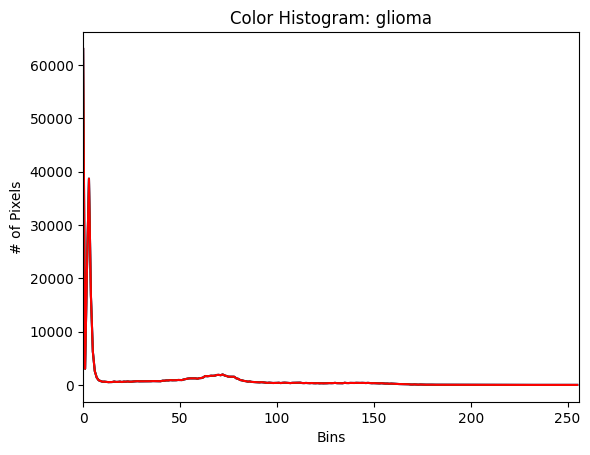

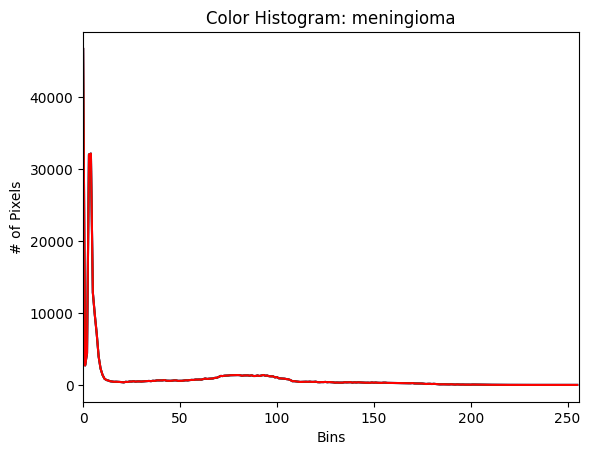

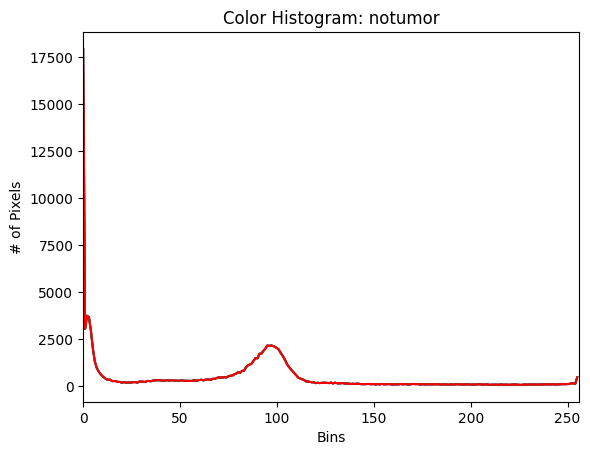

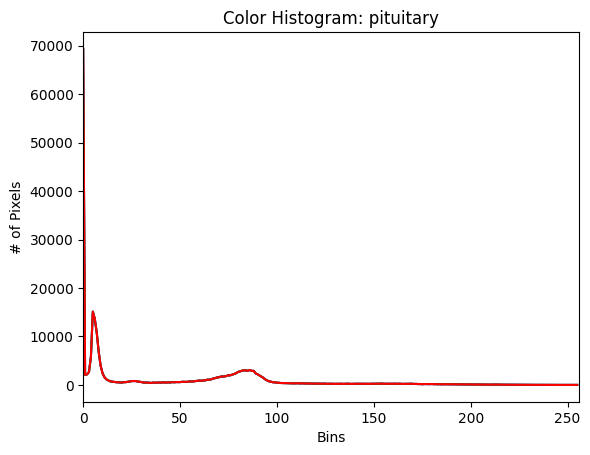

In [4]:
def plot_color_histogram(image_path, title):
    img = cv2.imread(image_path)
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    for chan, color in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.xlim([0, 256])
    plt.show()

for cat in categories:
    sample_path = glob(os.path.join(train_dir, cat, "*.jpg"))[0]
    plot_color_histogram(sample_path, f"Color Histogram: {cat}")


#### Histogram Aspek Ratio dan Resolution Scatter

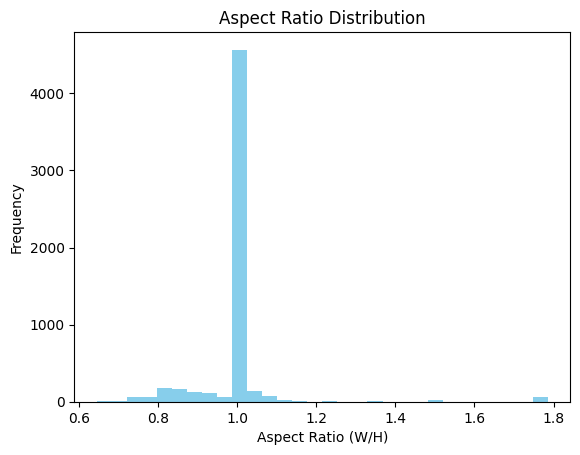

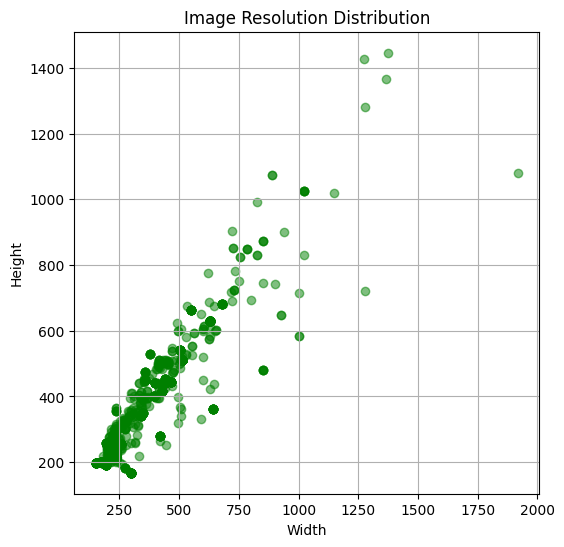

In [5]:
aspect_ratios = []
resolutions = []

for cat in categories:
    img_paths = glob(os.path.join(train_dir, cat, "*.jpg"))
    for path in img_paths:
        with Image.open(path) as img:
            width, height = img.size
            aspect_ratios.append(width / height)
            resolutions.append((width, height))

plt.hist(aspect_ratios, bins=30, color='skyblue')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (W/H)")
plt.ylabel("Frequency")
plt.show()

res_arr = np.array(resolutions)
plt.figure(figsize=(6,6))
plt.scatter(res_arr[:, 0], res_arr[:, 1], alpha=0.5, c='green')
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.grid(True)
plt.show()



Histogram aspect ratio menunjukkan kebanyakan gambar memiliki rasio mendekati 1:1, artinya bentuk gambar cenderung persegi.

#### Histogram Distribusi Kelas pada Training Set

C:\Users\user\AppData\Local\Temp\ipykernel_10604\265614534.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_train, palette='Set2')


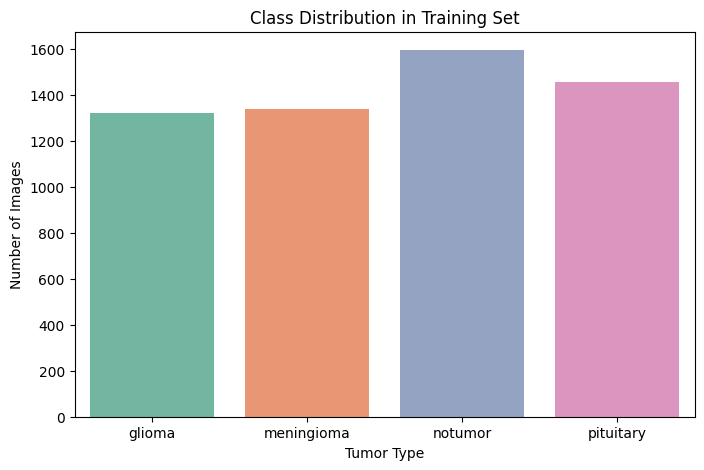

In [6]:
def get_class_distribution(path):
    data = []
    for category in categories:
        image_paths = glob(os.path.join(path, category, "*.jpg"))
        for img in image_paths:
            data.append(category)
    return pd.DataFrame({'label': data})

df_train = get_class_distribution(train_dir)

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_train, palette='Set2')
plt.title("Class Distribution in Training Set")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.show()


Jumlah gambar pada masing-masing kategori seperti glioma, meningioma, pituitary, dan notumor relatif seimbang, walaupun kelas notumor sedikit lebih banyak

#### Distribusi Histogram Width dan Height 

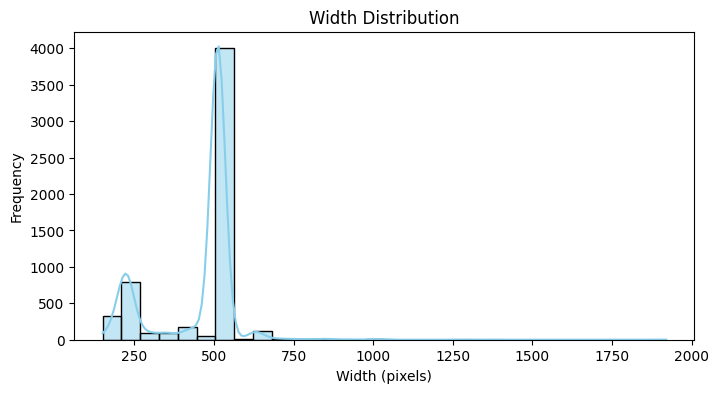

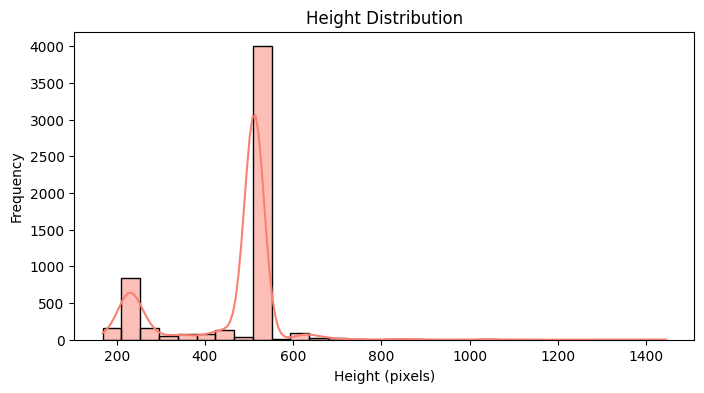

In [7]:
widths = []
heights = []

for cat in categories:
    img_paths = glob(os.path.join(train_dir, cat, "*.jpg"))
    for path in img_paths:
        with Image.open(path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

plt.figure(figsize=(8,4))
sns.histplot(widths, bins=30, kde=True, color='skyblue')
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.show()


plt.figure(figsize=(8,4))
sns.histplot(heights, bins=30, kde=True, color='salmon')
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")
plt.show()


Grafik ini menunjukkan distribusi lebar dan tinggi gambar, yang umumnya berada di sekitar 500 piksel, dengan beberapa gambar memiliki ukuran yang lebih kecil.
Hal ini menunjukkan bahwa dataset memiliki variasi ukuran, jadi perlu dilakukan resize agar model bisa dilatih dengan input gambar berukuran konsisten.


#### Histogram Variability (Brightness dan Angle)

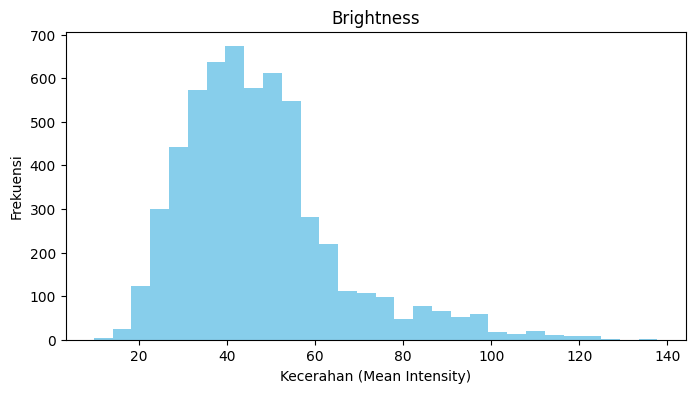

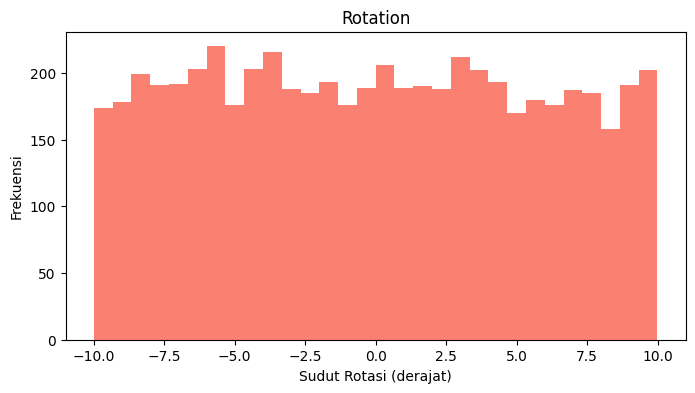

In [8]:
brightness_values = []
rotation_angles = []

def calculate_brightness(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    return np.mean(gray)  

def extract_rotation_angle(image_path):
    img = cv2.imread(image_path)
    
    return random.uniform(-10, 10)  

for cat in categories:
    img_paths = glob(os.path.join(train_dir, cat, "*.jpg"))
    for path in img_paths:
        brightness_values.append(calculate_brightness(path))
        rotation_angles.append(extract_rotation_angle(path))

plt.figure(figsize=(8,4))
plt.hist(brightness_values, bins=30, color='skyblue')
plt.title("Brightness")
plt.xlabel("Kecerahan (Mean Intensity)")
plt.ylabel("Frekuensi")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rotation_angles, bins=30, color='salmon')
plt.title("Rotation")
plt.xlabel("Sudut Rotasi (derajat)")
plt.ylabel("Frekuensi")
plt.show()


#### Menampilkan Gambar Acak per Kelas

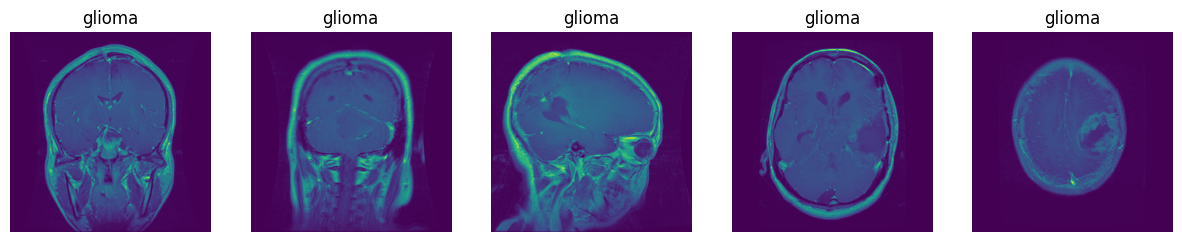

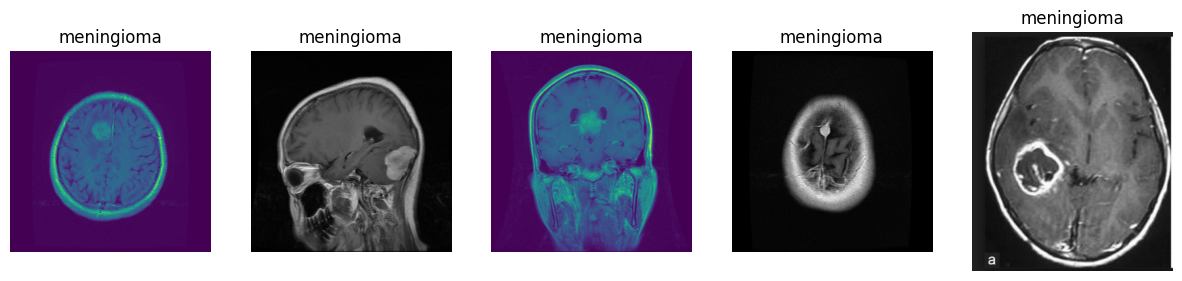

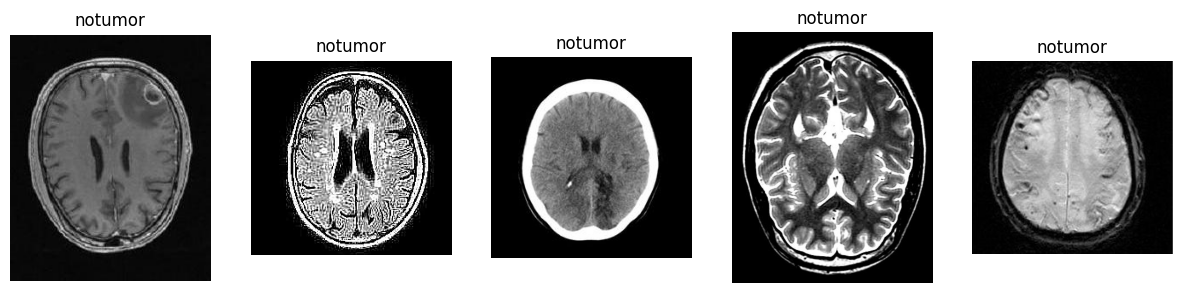

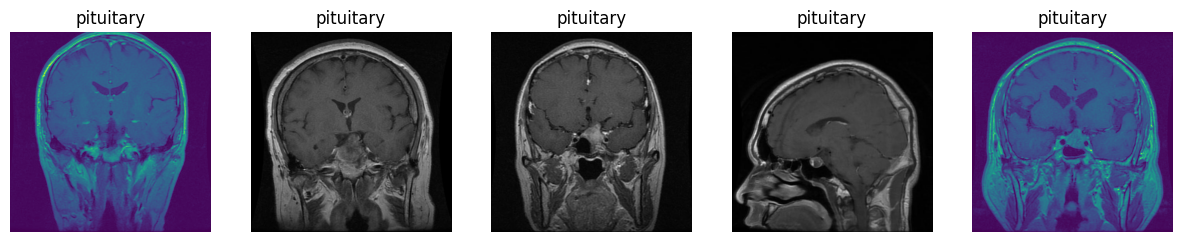

In [9]:
import random

def show_random_images(category):
    img_paths = glob(os.path.join(train_dir, category, "*.jpg"))
    sample_imgs = random.sample(img_paths, 5)
    plt.figure(figsize=(15,5))
    for i, path in enumerate(sample_imgs):
        img = Image.open(path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis("off")
    plt.show()

for cat in categories:
    show_random_images(cat)


Gambar diambil dengan berbagai orientasi dan kondisi pencahayaan

### Hasil EDA : 

##### 1. Distribusi Kelas Seimbang
    Dataset training memiliki distribusi kelas yang cukup seimbang antara glioma, meningioma, pituitary, dan notumor, meskipun kelas notumor sedikit lebih banyak. Hal ini baik untuk pelatihan model karena mengurangi risiko bias terhadap salah satu kelas.

#####  2. Histogram Warna Mengindikasikan Dominasi Intensitas Rendah
    Histogram warna dari sampel gambar menunjukkan bahwa sebagian besar pixel memiliki nilai intensitas rendah (gelap). Ini menandakan pencahayaan gambar umumnya redup, yang perlu dipertimbangkan dalam preprocessing dan augmentasi.

#####  3. Aspect Ratio Cenderung Mendekati 1:1
    Sebagian besar gambar memiliki aspect ratio mendekati persegi, memudahkan untuk di-resize ke dimensi input model CNN tanpa banyak distorsi.

#####  4. Ukuran Gambar Bervariasi
    Terdapat variasi cukup besar dalam dimensi gambar, khususnya pada lebar dan tinggi. Ukuran yang paling sering muncul sekitar 512 piksel, tetapi banyak juga gambar yang lebih kecil. Maka, resizing diperlukan untuk konsistensi input.

#####  5. Variasi Brightness Cukup Tinggi
    Tingkat kecerahan (mean intensity) pada gambar sangat bervariasi, menunjukkan adanya perbedaan pencahayaan yang signifikan antar gambar. Ini bisa mempengaruhi performa model jika tidak dilakukan normalisasi atau augmentasi.

#####  6. Variasi Sudut Pandang dan Orientasi
    Gambar dari setiap kelas memiliki perbedaan sudut pengambilan, rotasi, serta  pencahayaan. Ini menunjukkan pentingnya augmentasi data seperti rotasi, flipping, dan kontras agar model lebih robust terhadap perbedaan tersebut.

<span style="color: blue; font-size: 19px;">Data Preprocesing & Data Split</span>

#### Bedasarkan hasil EDA berikut data Preprocessing yang harus dilakukan: 

##### 1. Resize Gambar: 
    Karena ukuran gambar bervariasi, semua gambar sebaiknya diubah ke ukuran seragam 224x224

##### 2. Normalisasi Pixel: 
    Nilai intensitas piksel perlu dinormalisasi ke skala 0-1

##### 3. Augmentasi Data:
    - Rotasi
    - Horizontal/vertical
    - Zoom In/Out
    - Brightness Adjustment

##### 4. Split Data: Train, Validation, dan Test



#### Resize

In [10]:
img_size = (224, 224)
batch_size = 32

#### Normalisasi Pixel & Augmentasi 

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

- Rescaling piksel menjadi 0 hingga 1,
- Rotasi gambar hingga 10 derajat,
- Zoom in/out sebesar 10%,
- Flipping gambar secara horizontal.


#### Split Data untuk Train, Validation, dan Test

In [12]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


<span style="color: red; font-size: 19px;"> B. Baseline Model</span>

In [13]:
def create_alexnet(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4),
                     activation='relu', input_shape=input_shape,
                     padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    
    # Layer 2
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    
    # Layer 3
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                     activation='relu', padding='same'))
    
    # Layer 4
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                     activation='relu', padding='same'))
    
    # Layer 5
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1),
                     activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    
    # Flatten
    model.add(Flatten())
    
    # Layer 6
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
    # Layer 7
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer 
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (224, 224, 3) 
num_classes = 4  
model = create_alexnet(input_shape, num_classes)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()



C:\Users\user\anaconda3\envs\tf39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │          16,388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,764,804 (178.39 MB)

 Trainable params: 46,764,100 (178.39 MB)

 Non-trainable params: 704 (2.75 KB)

#### Training Model

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

C:\Users\user\anaconda3\envs\tf39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.5837 - loss: 1.1411 - val_accuracy: 0.3544 - val_loss: 1.4553
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.7849 - loss: 0.5279 - val_accuracy: 0.5813 - val_loss: 0.9977
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8539 - loss: 0.3849 - val_accuracy: 0.6795 - val_loss: 0.7989
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8832 - loss: 0.3023 - val_accuracy: 0.8573 - val_loss: 0.4448
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8988 - loss: 0.2653 - val_accuracy: 0.8456 - val_loss: 0.4452
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9311 - loss: 0.1987 - val_accuracy: 0.8819 - val_loss: 0.3584
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9336 - loss: 0.1754 - val_accuracy: 0.9123 - val_loss: 0.2924
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9534 - loss: 0.1381 - val_accu

#### Visualisasi Akurasi dan Loss Selama Training Model Baseline

41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8622 - loss: 0.3353

Test Accuracy: 91.84%
Test Loss: 0.2037


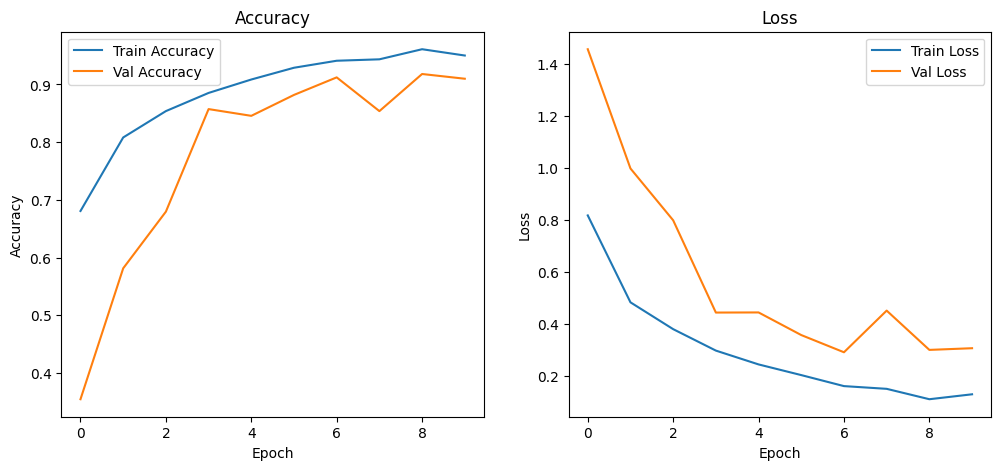

In [15]:
plt.figure(figsize=(12,5))
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Grafik Accuracy: Akurasi training meningkat secara konsisten hingga mendekati 95%, sementara akurasi validasi sempat fluktuatif tetapi stabil di sekitar 85–90%. 

Grafik Loss: Baik loss training maupun loss validasi secara umum mengalami penurunan, walaupun loss validasi sempat mengalami sedikit fluktuasi. 

<span style="color: red; font-size: 19px;"> C. Modifikasi</span>

#### Modifikasi yang akan di tambahkan
##### Conv2D + BatchNormalization
    Setiap layer Conv2D langsung diikuti dengan BatchNormalization.

##### Dropout (0.5) pada dua fully connected (Dense) layer.
    Dropout digunakan untuk mencegah overfitting dengan "mematikan" neuron secara acak saat training.

##### Learning Rate Schedule menggunakan ExponentialDecay.
    Learning rate berkurang secara bertahap agar model tidak overshooting dan bisa konvergen lebih halus.

##### Callback EarlyStopping
    Menghentikan training lebih awal jika val_loss tidak membaik, untuk efisiensi dan mencegah overfitting.

In [16]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

model_improved = Sequential()

model_improved.add(Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=(224, 224, 3)))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D((3, 3), strides=(2, 2)))

model_improved.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D((3, 3), strides=(2, 2)))

model_improved.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model_improved.add(BatchNormalization())

model_improved.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model_improved.add(BatchNormalization())

model_improved.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D((3, 3), strides=(2, 2)))

model_improved.add(Flatten())
model_improved.add(Dense(4096, activation='relu'))
model_improved.add(Dropout(0.5))
model_improved.add(Dense(4096, activation='relu'))
model_improved.add(Dropout(0.5))
model_improved.add(Dense(4, activation='softmax'))  # 4 classes

model_improved.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_improved.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │          16,3

 Total params: 46,768,900 (178.41 MB)

 Trainable params: 46,766,148 (178.40 MB)

 Non-trainable params: 2,752 (10.75 KB)

#### Training dengan Callback Fine Tuning

In [17]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

history_improved = model_improved.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.5887 - loss: 2.2347 - val_accuracy: 0.2550 - val_loss: 2.3137
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7552 - loss: 0.7762 - val_accuracy: 0.3708 - val_loss: 1.9322
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.7765 - loss: 0.6213 - val_accuracy: 0.6269 - val_loss: 1.1470
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8461 - loss: 0.4449 - val_accuracy: 0.3287 - val_loss: 2.8916
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.8705 - loss: 0.3673 - val_accuracy: 0.6398 - val_loss: 2.7178
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.8714 - loss: 0.3691 - val_accuracy: 0.6526 - val_loss: 1.0010
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9072 - loss: 0.2748 - val_accuracy: 0.8667 - val_loss: 0.4047
Epoch 8/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9215 - loss: 0.2231 - val_accu

In [18]:
loss, acc = model_improved.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}% | Test Loss: {loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 623ms/step - accuracy: 0.9152 - loss: 0.2249
Test Accuracy: 93.82% | Test Loss: 0.1790


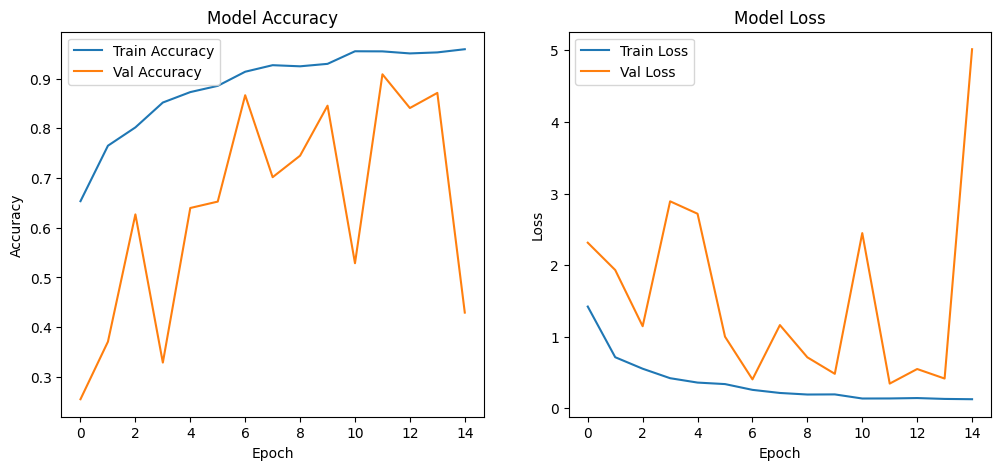

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_improved.history['accuracy'], label='Train Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_improved.history['loss'], label='Train Loss')
plt.plot(history_improved.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Grafik Accuracy: . Akurasi training meningkat secara konsisten seiring bertambahnya epoch, mencapai nilai yang sangat tinggi. Sementara itu, akurasi validasi menunjukkan tren yang stabil dengan fluktuasi kecil, namun tetap berada dalam rentang yang baik

Grafik Loss: Loss training menurun secara signifikan seiring berjalannya epoch, menunjukkan bahwa model terus mempelajari pola data dengan baik. Loss validasi juga mengalami penurunan, meskipun terdapat sedikit fluktuasi yang wajar dalam proses training.

<span style="color: red; font-size: 19px;"> D. Evaluasi</span>

#### Baseline Model

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 420ms/step
Baseline Accuracy: 0.9184
Baseline Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.77      0.87       300
  meningioma       0.80      0.92      0.85       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.99      0.97      0.98       300

    accuracy                           0.92      1311
   macro avg       0.93      0.91      0.91      1311
weighted avg       0.93      0.92      0.92      1311



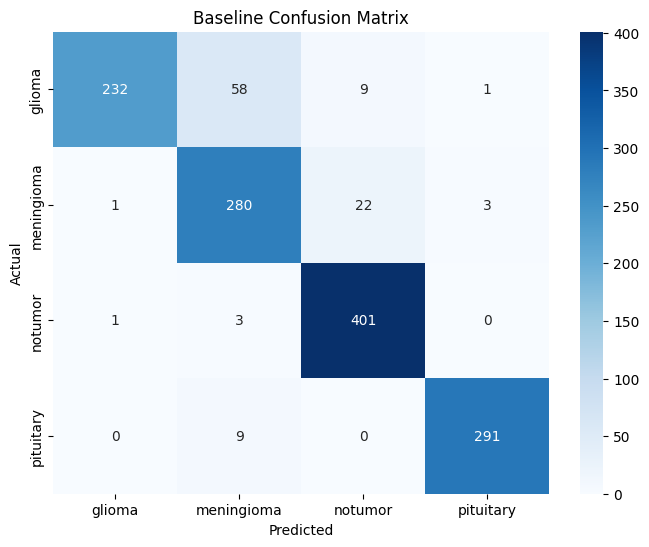

In [20]:
y_pred_probs_baseline = model.predict(test_generator, verbose=1)
y_pred_baseline = np.argmax(y_pred_probs_baseline, axis=1) 
y_true_baseline = test_generator.classes  

# Accuracy
accxy_baseline = accuracy_score(y_true_baseline, y_pred_baseline)
print(f"Baseline Accuracy: {accuracy_baseline:.4f}")

# Precision, Recall, F1-Score
class_names = list(test_generator.class_indices.keys())  # Nama kelas
report_baseline = classification_report(y_true_baseline, y_pred_baseline, target_names=class_names)
print("Baseline Classification Report:\n", report_baseline)

# Confusion Matrix
cm_baseline = confusion_matrix(y_true_baseline, y_pred_baseline)
plt.figure(figsize=(8,6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Baseline Confusion Matrix")
plt.show()


 ### Analisis
 
 ##### Accuracy
 Model baseline yang dibangun menunjukkan performa yang cukup baik dalam klasifikasi gambar MRI otak berdasarkan jenis tumo dengan akurasi keseluruhan sebesar 91.84%.
 
 ##### Classification Report
Glioma

    Precision: 0.99 → Hampir semua yang diprediksi sebagai glioma memang benar glioma.

    Recall: 0.77 → Tapi model hanya menangkap 77% dari semua kasus glioma yang sebenarnya ada. Jadi masih banyak yang terlewat.

    F1-score: 0.87 

Meningioma

    Precision: 0.80 → Dari semua prediksi meningioma, 80% benar.

    Recall: 0.92 → Model cukup sensitif, bisa menangkap 92% kasus meningioma.

    F1-score: 0.85

Notumor (tidak ada tumor)

    Precision & Recall tinggi (0.93 dan 0.99) → Model sangat bagus untuk mengenali kondisi ini.

    F1-score: 0.96

Pituitary

    Precision: 0.99, Recall: 0.97 → Model hampir sempurna.

    F1-score: 0.98
 
 ##### Confusion Matrix
 
 1. Glioma

    Prediksi benar: 232 gambar dikenali sebagai glioma secara tepat.

    Prediksi salah:

        58 dikira meningioma,

        1 dikira pituitary,

        9 dikira notumor.

    Kesimpulan: Model cukup baik dalam mengenali glioma, tetapi masih ada sedikit kebingungan dengan meningioma dan notumor.

2. Meningioma

    Prediksi benar: 280 gambar dikenali dengan benar.

    Prediksi salah:

        1 dikira glioma,

        22 dikira notumor,

        3 dikira pituitary.

    Kesimpulan: Inilah kelas yang paling sering salah diprediksi. Banyak citra meningioma dikira sebagai glioma. Ini menunjukkan fitur meningioma cenderung mirip dengan glioma atau belum cukup dikenali dengan baik oleh model.

3. Notumor

    Prediksi benar: 401 gambar dikenali dengan sangat baik.

    Prediksi salah:

        1 dikira glioma,

        3 dikira meningioma,

        0 dikira pituitary.

    Kesimpulan: Model sangat andal untuk mendeteksi gambar tanpa tumor. Ini penting karena salah diagnosis "tidak ada tumor" bisa sangat krusial.

4. Pituitary

    Prediksi benar: 291 gambar dikenali dengan benar.

    Prediksi salah:

        0 dikira glioma,

        9 dikira meningioma,

        0 dikira notumor.

    Kesimpulan: Performa model dalam mengklasifikasikan pituitary tumor juga sangat baik, meski ada sedikit overlap ke kelas meningioma.



#### Modification Model

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 547ms/step
Improved Accuracy: 0.9382
Improved Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.90      0.93       300
  meningioma       0.87      0.90      0.88       306
     notumor       0.94      0.97      0.96       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



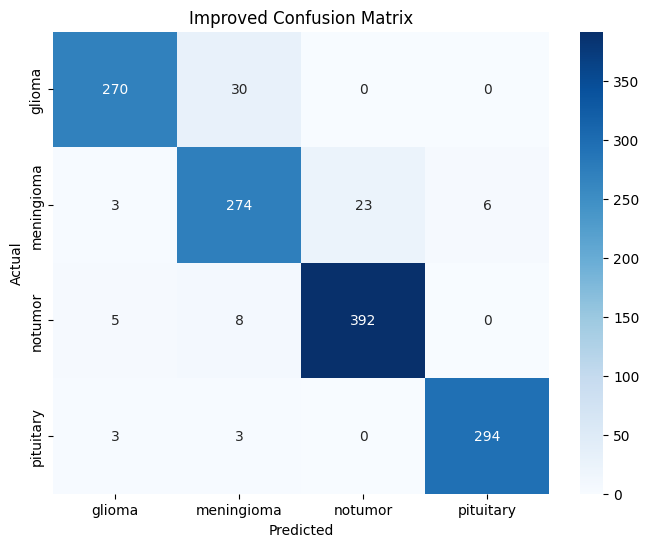

In [21]:
y_pred_probs_improved = model_improved.predict(test_generator)
y_pred_improved = np.argmax(y_pred_probs_improved, axis=1)
y_true_improved = test_generator.classes

# Accuracy
accuracy_improved = accuracy_score(y_true_improved, y_pred_improved)
print(f"Improved Accuracy: {accuracy_improved:.4f}")

# Precision, Recall, F1-Score
class_names = list(test_generator.class_indices.keys())
report_improved = classification_report(y_true_improved, y_pred_improved, target_names=class_names)
print("Improved Classification Report:\n", report_improved)

# Confusion Matrix
cm_improved = confusion_matrix(y_true_improved, y_pred_improved)
plt.figure(figsize=(8,6))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Improved Confusion Matrix")
plt.show()

##### Accuracy
Accuracy: 93.82%
Naik dari model baseline yang 91.84%.

##### Classification Report

1. Glioma

        Precision: 0.96 → Hampir semua prediksi glioma benar.

        Recall: 0.90 → Model berhasil menangkap 90% kasus glioma.

        F1-score: 0.93 → Jauh membaik dari baseline (yang 0.87).

2. Meningioma

        Precision: 0.87, Recall: 0.90 → Naik sedikit dari baseline, lebih seimbang sekarang.

        F1-score: 0.88 → Lebih stabil dan konsisten.

3. Notumor

        Precision: 0.94, Recall: 0.97 → Masih sangat tinggi dan tetap bagus seperti baseline.

        F1-score: 0.96

4. Pituitary

        Precision & Recall: 0.98 → Tetap sangat kuat, hampir sempurna.

        F1-score: 0.98

Macro Avg & Weighted Avg semua di angka 0.94, artinya performa meningkat merata di semua kelas.

##### Confusion Matrix

1. Glioma

    Prediksi benar: 270 gambar dikenali sebagai glioma secara tepat.

    Prediksi salah:

        30 dikira meningioma,

        0 dikira notumor,

        0 dikira pituitary.

Kesimpulan: Model improved jauh lebih baik dalam mengenali glioma dibanding baseline. Tidak ada lagi kebingungan dengan kelas lain selain sedikit dengan meningioma. Ini menunjukkan peningkatan signifikan pada recall glioma.

2. Meningioma

    Prediksi benar: 274 gambar dikenali dengan benar.

    Prediksi salah:

        3 dikira glioma,

        23 dikira notumor,

        6 dikira pituitary.

Kesimpulan: Meningioma masih merupakan kelas yang cukup sulit bagi model. Masih banyak tertukar dengan notumor. Ini bisa berarti fitur meningioma masih belum cukup spesifik atau terlalu mirip dengan notumor di mata model.

3. Notumor

    Prediksi benar: 392 gambar dikenali dengan sangat baik.

    Prediksi salah:

        5 dikira glioma,

        8 dikira meningioma,

        0 dikira pituitary.

Kesimpulan: Model tetap sangat andal dalam mengenali gambar tanpa tumor. Performa ini penting karena kesalahan pada kasus "tidak ada tumor" bisa berdampak serius dalam diagnosa.

4. Pituitary

    Prediksi benar: 294 gambar dikenali dengan benar.

    Prediksi salah:

        3 dikira glioma,

        3 dikira meningioma,

        0 dikira notumor.

Kesimpulan: Model improved tetap menunjukkan performa tinggi pada kelas pituitary. Hanya beberapa kasus salah klasifikasi ke glioma dan meningioma, tetapi secara umum sangat akurat.

#### Kesimpulan

Setelah dilakukan modifikasi pada model, akurasi keseluruhan meningkat dari 91,84% menjadi 93,82%. Ini menunjukkan bahwa model improved lebih andal dalam mengklasifikasikan citra MRI tumor otak.

Peningkatan paling signifikan terjadi pada kelas glioma, di mana sebelumnya model hanya mampu mengenali sekitar 77% kasus dengan benar. Setelah modifikasi, recall meningkat menjadi 90%, dan f1-score naik dari 0.87 ke 0.93. Hal ini menunjukkan bahwa model jauh lebih sensitif terhadap deteksi glioma, yang sebelumnya merupakan titik lemah.

Untuk kelas meningioma, performa juga meningkat secara stabil. Meskipun masih ada kesalahan klasifikasi ke kelas notumor dan pituitary, f1-score-nya naik menjadi 0.88, menunjukkan prediksi yang lebih seimbang.

Kelas notumor dan pituitary tetap menunjukkan performa yang sangat baik. Akurasi dan f1-score keduanya tetap tinggi, masing-masing di angka 0.96 dan 0.98, yang menandakan bahwa modifikasi tidak mengorbankan performa pada kelas lain.

Dari confusion matrix juga terlihat bahwa jumlah kesalahan klasifikasi pada glioma menurun drastis, sementara kelas-kelas lain tetap stabil atau membaik.

Secara keseluruhan, modifikasi yang dilakukan berhasil membuat model menjadi lebih akurat, seimbang, dan andal dalam mendeteksi keempat jenis citra, yaitu glioma, meningioma, pituitary, dan kondisi tanpa tumor.

<span style="color: red; font-size: 19px;"> E. Video Presentasi</span>

Video Link: https://drive.google.com/file/d/1D2zrn_M2XntIUFdTR0SwrlgfdDuDnXrw/view?usp=sharing